## reference
https://www.kaggle.com/robikscube/helper-code-helmet-mapping-deepsort

In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
from external_lib.NFLlib.score import NFLAssignmentScorer, check_submission
from external_lib.NFLlib.features import add_track_features

In [3]:
import numpy as np
import pandas as pd
import itertools
import glob
import os
import cv2
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
from multiprocessing import Pool
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import random

from lib.io import load_json
from lib.noglobal import noglobal

## settings and loadning

In [4]:
n_test_videos = len(glob.glob("/work/data/input/nfl-health-and-safety-helmet-assignment/test/*"))

if n_test_videos == 6:
    debug = True;
else:
    debug = False
    

config = load_json("/work/config/baseconfig.json");    
n_debug_samples = config["experiments"]["n_debug_samples"];
random_state = config["experiments"]["random_state"];
CONF_THRE = config["experiments"]["CONF_THRE"];
max_iter = config["experiments"]["max_iter"];
DIG_STEP = config["experiments"]["DIG_STEP"];
DIG_MAX = config["experiments"]["DIG_MAX"];

base_dir = config["base_dir"];

labels = pd.read_csv(f"{base_dir}/train_labels.csv")

if debug:
    tracking = pd.read_csv(f'{base_dir}/train_player_tracking.csv')
    helmets = pd.read_csv(f'{base_dir}/train_baseline_helmets.csv')
else:
    tracking = pd.read_csv(f'{base_dir}/test_player_tracking.csv')
    helmets = pd.read_csv(f'{base_dir}/test_baseline_helmets.csv')
    
tracking = add_track_features(tracking)

In [5]:
def add_cols(df):
    df['game_play'] = df['video_frame'].str.split('_').str[:2].str.join('_')
    if 'video' not in df.columns:
        df['video'] = df['video_frame'].str.split('_').str[:3].str.join('_') + '.mp4'
    return df

if debug:
    helmets = add_cols(helmets)
    labels = add_cols(labels)
    
    # Select `n_debug_samples` worth of videos to debug with
    sample_videos = labels['video'].drop_duplicates() \
        .sample(n_debug_samples, random_state=random_state).tolist()
    sample_gameplays = ['_'.join(x.split('_')[:2]) for x in sample_videos]
    tracking = tracking[tracking['game_play'].isin(sample_gameplays)]
    helmets = helmets[helmets['video'].isin(sample_videos)]
    labels = labels[labels['video'].isin(sample_videos)]
tracking.shape, helmets.shape, labels.shape

((6424, 18), (8746, 8), (7888, 15))

In [6]:
@noglobal()
def find_nearest(array, value):
    
    value = int(value)
    array = np.asarray(array).astype(int)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


### [0,1]ではないけど、正規化？
@noglobal()
def norm_arr(a):
    a = a-a.min();
    a = a/(a.max()-a.min());
    return a
    
@noglobal()
def dist(a1,a2):
    return np.linalg.norm(a1-a2);

@noglobal()
def dist_for_different_len(a1,a2,max_iter):
    assert len(a1) >= len(a2), f'{len(a1)}, {len(a2)}'
    
    len_diff = len(a1) - len(a2);

    a2 = norm_arr(a2);
    
    if len_diff == 0:
        a1 = norm_arr(a1);
        return dist(a1,a2),();
    else:
        min_dist = 10000;
        min_delete_idx = None;
        cnt = 0;
        
        del_list = list(itertools.combinations(range(len(a1)),len_diff));
        
        
        ## 組み合わせの総数が指定した数より大きい場合、ランダムサンプリングする。。
        if (len(del_list) > max_iter):
            del_list = random.sample(del_list,max_iter);
            
        for delete_idx in del_list:
            this_a1 = np.delete(a1,delete_idx);
            this_a1 = norm_arr(this_a1);
            this_dist = dist(this_a1,a2);
            
            if (min_dist > this_dist):
                min_dist = this_dist
                min_delete_idx = delete_idx;
            
            
        return min_dist,min_delete_idx
    

@noglobal()
def rotate_arr(u, t, isDeg=True):
    if isDeg:
        t = np.deg2rad(t);
        
    Rotation_matrix = np.array(  
        [[np.cos(t),-np.sin(t)],
        [np.sin(t),np.cos(t)]]    
    )
    return Rotation_matrix@u
    


@noglobal(excepts = ["rotate_arr"])
def dist_rot(tracking_df, a2,DIG_MAX,DIG_STEP,max_iter):
    tracking_df = tracking_df.sort_values('x')
    x = tracking_df['x']
    y = tracking_df['y']
    min_dist = 10000
    min_idx = None
    min_x = None
    for dig in range(-DIG_MAX,DIG_MAX+1,DIG_STEP):
        
        ## コートの４角の一つを中心としたときの座標変換
        ## x: コートの長い方に沿ったときの位置
        ## y: コートの短い方に沿ったときの位置
        ## arr: 座標変換後のプレイヤーの位置
        arr = rotate_arr(np.array((x,y)), dig)
        
        ##  a2: ヘルメットの座標        
        this_dist, this_idx = dist_for_different_len(np.sort(arr[0]), a2,max_iter)
        if min_dist > this_dist:
            min_dist = this_dist
            min_idx = this_idx
            min_x = arr[0]
    tracking_df['x_rot'] = min_x
    player_arr = tracking_df.sort_values('x_rot')['player'].values
    players = np.delete(player_arr,min_idx)
    return min_dist, players        
        
    


@noglobal()
def mapping_df(args):
    video_frame, df = args[:2]
    
    parameter = args[2]
    
    tracking = parameter["tracking"]
    CONF_THRE = parameter["CONF_THRE"];
    DIG_STEP = parameter["DIG_STEP"];
    DIG_MAX = parameter["DIG_MAX"];
    max_iter = parameter["max_iter"];
    
    gameKey,playID,view,frame = video_frame.split('_')
    
    gameKey = int(gameKey)
    playID = int(playID)
    frame = int(frame)
    
    
    this_tracking = tracking[(tracking['gameKey']==gameKey) & (tracking['playID']==playID)]
    est_frame = find_nearest(this_tracking["est_frame"].values, frame)
    this_tracking = this_tracking[this_tracking['est_frame']==est_frame]    
    len_this_tracking = len(this_tracking)
    df['center_h_p'] = (df['left']+df['width']/2).astype(int)
    df['center_h_m'] = (df['left']+df['width']/2).astype(int)*-1
    df = df[df['conf']>CONF_THRE].copy()
    if len(df) > len_this_tracking:
        df = df.tail(len_this_tracking)
    df_p = df.sort_values('center_h_p').copy()
    df_m = df.sort_values('center_h_m').copy()
    
    if view == 'Endzone':
        this_tracking['x'], this_tracking['y'] = this_tracking['y'].copy(), this_tracking['x'].copy()
    a2_p = df_p['center_h_p'].values
    a2_m = df_m['center_h_m'].values

    min_dist_p, min_detete_idx_p = dist_rot(this_tracking ,a2_p,DIG_MAX,DIG_STEP,max_iter)
    min_dist_m, min_detete_idx_m = dist_rot(this_tracking ,a2_m,DIG_MAX,DIG_STEP,max_iter)
    if min_dist_p < min_dist_m:
        min_dist = min_dist_p
        min_detete_idx = min_detete_idx_p
        tgt_df = df_p
    else:
        min_dist = min_dist_m
        min_detete_idx = min_detete_idx_m
        tgt_df = df_m
    #print(video_frame, len(this_tracking), len(df), len(df[df['conf']>CONF_THRE]), this_tracking['x'].mean(), min_dist_p, min_dist_m, min_dist)
    tgt_df['label'] = min_detete_idx
    return tgt_df[['video_frame','left','width','top','height','label']]
            
        
        
        
            
        
        
        
        
        
        
    
    
    
    
    

In [7]:
submission_df_list = []
df_list = list(helmets.groupby('video_frame'))
paramater = config["experiments"].copy();
paramater["tracking"] = tracking
df_list = [ list(element) + [paramater] for element in df_list];

from lib.multiprocess import exe_multiprocess_ret_as_list


submission_df_list = exe_multiprocess_ret_as_list(mapping_df,df_list);

submission_df = pd.concat(submission_df_list)
submission_df.to_csv('submission-baseline.csv', index=False)

100%|██████████| 451/451 [02:00<00:00,  3.73it/s]


In [8]:
if debug:
    scorer = NFLAssignmentScorer(labels)
    baseline_score = scorer.score(submission_df)
    print(f"validation score {baseline_score:0.4f}")

validation score 0.2756


## Deep Sort

In [9]:
from external_lib.deep_sort_pytorch.utils.parser import get_config
from external_lib.deep_sort_pytorch.deep_sort import DeepSort

In [10]:
def compute_color_for_id(label):
    """
    Simple function that adds fixed color depending on the id
    """
    palette = (2 ** 11 - 1, 2 ** 15 - 1, 2 ** 20 - 1)

    color = [int((p * (label ** 2 - label + 1)) % 255) for p in palette]
    return tuple(color)

def plot_one_box(x, im, color=None, label=None, line_thickness=3):
    # Plots one bounding box on image 'im' using OpenCV
    assert im.data.contiguous, 'Image not contiguous. Apply np.ascontiguousarray(im) to plot_on_box() input image.'
    tl = line_thickness or round(0.002 * (im.shape[0] + im.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(im, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label: 
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(im, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(im, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
    return im

In [11]:

def deepsort_helmets(video_data,
                     video_dir,
                     deepsort_config='/work/config/deepsort.yaml',
                     plot=False,
                     plot_frames=[]):
    
    # Setup Deepsort
    cfg = get_config()
    cfg.merge_from_file(deepsort_config)    
    deepsort = DeepSort(cfg.DEEPSORT.REID_CKPT,
                        max_dist=cfg.DEEPSORT.MAX_DIST,
                        min_confidence=cfg.DEEPSORT.MIN_CONFIDENCE,
                        nms_max_overlap=cfg.DEEPSORT.NMS_MAX_OVERLAP,
                        max_iou_distance=cfg.DEEPSORT.MAX_IOU_DISTANCE,
                        max_age=cfg.DEEPSORT.MAX_AGE,
                        n_init=cfg.DEEPSORT.N_INIT,
                        nn_budget=cfg.DEEPSORT.NN_BUDGET,
                        use_cuda=True)
    
    # Run through frames.
    video_data = video_data.sort_values('frame').reset_index(drop=True)
    ds = []
    for frame, d in tqdm(video_data.groupby(['frame']), total=video_data['frame'].nunique()):
        d['x'] = (d['left'] + round(d['width'] / 2))
        d['y'] = (d['top'] + round(d['height'] / 2))

        xywhs = d[['x','y','width','height']].values

        cap = cv2.VideoCapture(f'{video_dir}/{myvideo}.mp4')
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame-1) # optional
        success, image = cap.read()
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        confs = np.ones([len(d),])
        clss =  np.zeros([len(d),])
        outputs = deepsort.update(xywhs, confs, clss, image)

        if (plot and frame > cfg.DEEPSORT.N_INIT) or (frame in plot_frames):
            for j, (output, conf) in enumerate(zip(outputs, confs)): 

                bboxes = output[0:4]
                id = output[4]
                cls = output[5]

                c = int(cls)  # integer class
                label = f'{id}'
                color = compute_color_for_id(id)
                im = plot_one_box(bboxes, image, label=label, color=color, line_thickness=2)
            fig, ax = plt.subplots(figsize=(15, 10))
            video_frame = d['video_frame'].values[0]
            ax.set_title(f'Deepsort labels: {video_frame}')
            plt.imshow(im)
            plt.show()

        preds_df = pd.DataFrame(outputs, columns=['left','top','right','bottom','deepsort_cluster','class'])
        if len(preds_df) > 0:
            # TODO Fix this messy merge
            d = pd.merge_asof(d.sort_values(['left','top']),
                              preds_df[['left','top','deepsort_cluster']] \
                              .sort_values(['left','top']), on='left', suffixes=('','_deepsort'),
                              direction='nearest')
        ds.append(d)
    dout = pd.concat(ds)
    return dout


def add_deepsort_label_col(out):
    # Find the top occuring label for each deepsort_cluster
    sortlabel_map = out.groupby('deepsort_cluster')['label'].value_counts() \
        .sort_values(ascending=False).to_frame() \
        .rename(columns={'label':'label_count'}) \
        .reset_index() \
        .groupby(['deepsort_cluster']) \
        .first()['label'].to_dict()
    # Find the # of times that label appears for the deepsort_cluster.
    sortlabelcount_map = out.groupby('deepsort_cluster')['label'].value_counts() \
        .sort_values(ascending=False).to_frame() \
        .rename(columns={'label':'label_count'}) \
        .reset_index() \
        .groupby(['deepsort_cluster']) \
        .first()['label_count'].to_dict()
    
    out['label_deepsort'] = out['deepsort_cluster'].map(sortlabel_map)
    out['label_count_deepsort'] = out['deepsort_cluster'].map(sortlabelcount_map)

    return out


def score_vs_deepsort(myvideo, out, labels):
    # Score the base predictions compared to the deepsort postprocessed predictions.
    myvideo_mp4 = myvideo + '.mp4'
    labels_video = labels.query('video == @myvideo_mp4')
    scorer = NFLAssignmentScorer(labels_video)
    out_deduped = out.groupby(['video_frame','label']).first().reset_index()
    base_video_score = scorer.score(out_deduped)
    
    out_preds = out.drop('label', axis=1).rename(columns={'label_deepsort':'label'})
    print(out_preds.shape)
    out_preds = out_preds.groupby(['video_frame','label']).first().reset_index()
    print(out_preds.shape)
    deepsort_video_score = scorer.score(out_preds)
    print(f'{base_video_score:0.5f} before --> {deepsort_video_score:0.5f} deepsort')

## main

  0%|          | 0/1 [00:00<?, ?it/s]

57783_003374_Endzone
==== 57783_003374_Endzone ====


  0%|          | 0/451 [00:00<?, ?it/s]

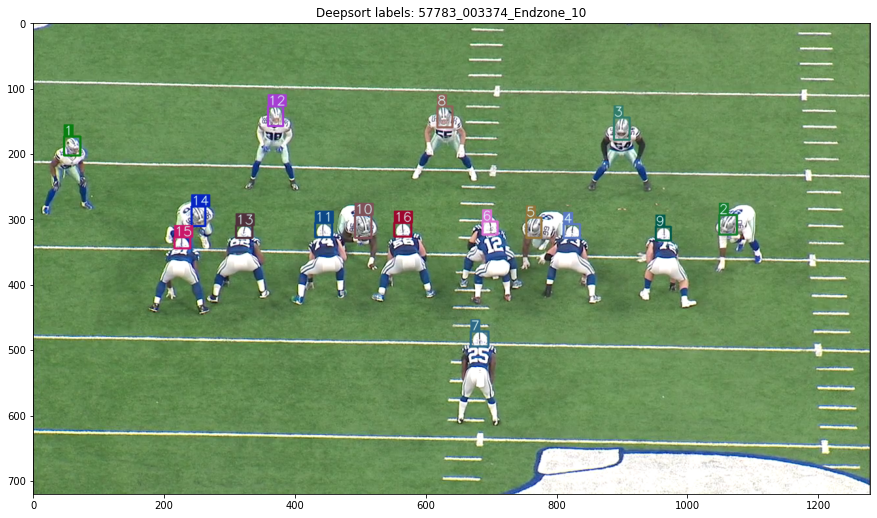

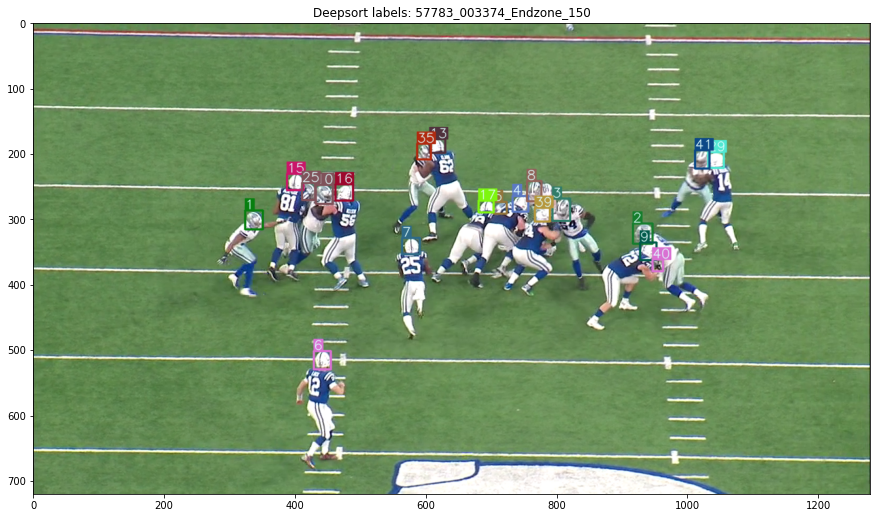

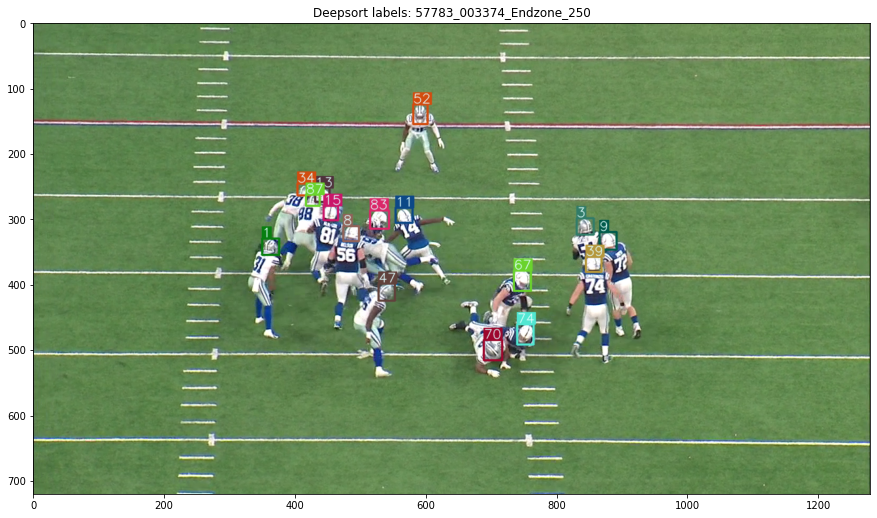

(7840, 13)
(6997, 13)
0.27558 before --> 0.63262 deepsort


In [12]:
# Add video and frame columns to submission.
submission_df['video'] = submission_df['video_frame'].str.split('_').str[:3].str.join('_')
submission_df['frame'] = submission_df['video_frame'].str.split('_').str[-1].astype('int')

labels = pd.read_csv(f"{base_dir}/train_labels.csv")

if debug:
    video_dir = f"{base_dir}/train/"
else:
    video_dir = f"{base_dir}/test/"

    
    

# Loop through test videos and apply. If in debug mode show the score change.
outs = []
for myvideo, video_data in tqdm(submission_df.groupby('video'), total=submission_df['video'].nunique()):
    print(myvideo)
    print(f'==== {myvideo} ====')
    
    
    if debug:
        # Plot deepsort labels when in debug mode.
        out = deepsort_helmets(video_data, video_dir, plot_frames=[10, 150, 250])
    else:
        out = deepsort_helmets(video_data, video_dir)        
    out = add_deepsort_label_col(out)
    outs.append(out)
    if debug:        
        score_vs_deepsort(myvideo, out, labels)
        
    
submission_deepsort = pd.concat(outs).copy()